# About the project
The work is all about tackling software effort prediction (SEP) and software test prediction (STP) (i.e., software reliability problems) by integrating a metaheuristicm algorith with a ML model to optimize the model's parameters.
Here JAYA algorithm is used in other to improve a Support Vector Regressor SVR model's predictions (predicting the Software effort). Using the Jaya algorithm to optimize the SVR parameters (C, epsilon, gamma).

- The final goal of the project is to compare the results gotten with the results published in a paper by  Sofian Kassaymeh, Salwani Abdullah, Mohamad Al-Laham and others, titled: Salp Swarm Optimizer for Modeling Software Reliability Prediction Problem.
- The same datasets are used.

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [2]:
# Load dataset
df = pd.read_csv("dataset/miyazaki94.csv")
df = df.drop("ID", axis=1)
df.head()

,KLOC,SCRN,FORM,FILE,ESCRN,EFORM,EFILE,MM
0,44.2,24.0,26.0,41.0,246.0,642.0,589.0,59.5
1,59.0,34.0,30.0,28.0,651.0,447.0,1143.0,85.0
2,36.9,9.0,36.0,29.0,193.0,694.0,995.0,31.5
3,39.3,27.0,10.0,52.0,389.0,105.0,2344.0,58.9
4,48.3,21.0,22.0,20.0,241.0,371.0,2052.0,58.9


# Option 1: Run model and Predictions without Feature Selection

In [3]:
X = df.drop(columns=["MM"])
y = df["MM"]

In [4]:
# Scale features and target
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

In [5]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

## SVR only

In [6]:
# Running the SVR model only without JAYA optimization
model1 = SVR(C=100, epsilon=0.1, gamma=0.005)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
mse = mean_squared_error(y_test, y_pred1)
mse

0.014037098682665904

In [7]:
y_predr = scaler_y.inverse_transform(y_pred1.reshape(-1, 1))  # Reverse scaling to get the original values
y_testr = scaler_y.inverse_transform(y_test.reshape(-1, 1))
print(y_predr[:6])
print(y_testr[:6])
print("mse: ", mean_squared_error(y_testr, y_predr))

[[ 63.51531584]
 [ 75.50945276]
 [128.79152446]
 [ 26.79642631]
 [ 67.58295548]
 [ 44.62778892]]
[[ 39. ]
 [ 55.7]
 [157. ]
 [  6. ]
 [ 54. ]
 [ 22. ]]
mse:  719.2720345809466


## SVR with JAYA optimization

In [8]:
def fitness_function(params, X_train, y_train):
    try:
        C, epsilon, gamma = params
        model = SVR(C=C, epsilon=epsilon, gamma=gamma)
        
        # Use cross-validation on the training set
        # train on 80% of training data, validate on 20%
        X_train_train, X_val, y_train_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42)
        
        model.fit(X_train_train, y_train_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        return mse
    except:
        return float('inf')

In [9]:
def jaya_optimizer(fitness_fn, bounds, pop_size=10, iterations=100):
    dim = len(bounds)
    population = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds], size=(pop_size, dim))
    mse_per_iter = []

    for it in range(iterations):
        fitness_values = [fitness_fn(ind, X_train, y_train) for ind in population]
        best_idx, worst_idx = np.argmin(fitness_values), np.argmax(fitness_values)
        best, worst = population[best_idx], population[worst_idx]

        for i in range(pop_size):
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            new_ind = population[i] + r1 * (best - abs(population[i])) - r2 * (worst - abs(population[i]))
            new_ind = np.clip(new_ind, [b[0] for b in bounds], [b[1] for b in bounds])
            new_fit = fitness_fn(new_ind, X_train, y_train)
            if new_fit < fitness_values[i]:
                population[i] = new_ind

        mse_per_iter.append(min(fitness_values))

    final_fitness = [fitness_fn(ind, X_train, y_train) for ind in population]
    best_index = np.argmin(final_fitness)
    return population[best_index], final_fitness[best_index], mse_per_iter

In [10]:
# SVR hyperparameter bounds: C, epsilon, gamma
bounds = [(100, 1000), (0.05, 0.2), (0.001, 0.005)]

In [11]:
best_params, best_mse, mse_progression = jaya_optimizer(fitness_function, bounds, pop_size=10, iterations=100)

print("Best Parameters (C, epsilon, gamma):", best_params)
print("Best MSE on validation set:", best_mse)

Best Parameters (C, epsilon, gamma): [1.00010311e+02 5.00000000e-02 2.89870754e-03]
Best MSE on validation set: 0.009766774781646954


In [12]:
# Now evaluate the best model on the test set (unseen data)
best_model = SVR(C=best_params[0], epsilon=best_params[1], gamma=best_params[2])
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE on unseen data:", test_mse)

Test MSE on unseen data: 0.013353536085011877


In [13]:
y_test_predr = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))  # Reverse scaling to get the original values
y_testr = scaler_y.inverse_transform(y_test.reshape(-1, 1))
print(y_predr[:6])
print(y_testr[:6])
print("mse: ", mean_squared_error(y_testr, y_test_predr))

[[ 63.51531584]
 [ 75.50945276]
 [128.79152446]
 [ 26.79642631]
 [ 67.58295548]
 [ 44.62778892]]
[[ 39. ]
 [ 55.7]
 [157. ]
 [  6. ]
 [ 54. ]
 [ 22. ]]
mse:  684.245746635476


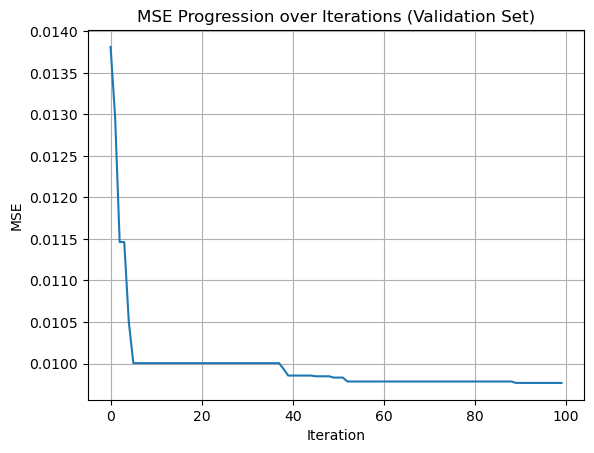

In [14]:
plt.plot(mse_progression)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("MSE Progression over Iterations (Validation Set)")
plt.grid(True)
plt.show()

# Option 2: Implementing Feature Selections 

- The model's MSE value from option 1: SVR only will be used as a baseline value to see if the feature selections helps in improving the model's performance

In [15]:
df2 = df.copy()

In [16]:
df2.head()

,KLOC,SCRN,FORM,FILE,ESCRN,EFORM,EFILE,MM
0,44.2,24.0,26.0,41.0,246.0,642.0,589.0,59.5
1,59.0,34.0,30.0,28.0,651.0,447.0,1143.0,85.0
2,36.9,9.0,36.0,29.0,193.0,694.0,995.0,31.5
3,39.3,27.0,10.0,52.0,389.0,105.0,2344.0,58.9
4,48.3,21.0,22.0,20.0,241.0,371.0,2052.0,58.9


In [17]:
# Feature Selection: Step 1 -> Pearson Correlation
df2.corrwith(df['MM']).drop("MM")

KLOC     0.735055
SCRN     0.842066
FORM     0.626092
FILE     0.958175
ESCRN    0.651625
EFORM    0.340867
EFILE    0.975164
dtype: float64

In [18]:
# From the values above, EFORM has the lowest cor with our target. We'll drop it, including FORM... just to have all the cor value be 0.65 and above
X1 = df2.drop(["EFORM", "FORM", "MM"], axis=1)
y1 = df2["MM"]

In [19]:
# Scale features and target
X1_scaled = scaler_x.fit_transform(X1)
y1_scaled = scaler_y.fit_transform(y1.values.reshape(-1, 1)).flatten()

In [20]:
# Split dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1_scaled, y1_scaled, test_size=0.2, random_state=42)

In [21]:
# Running the SVR model only without JAYA optimization
model1 = SVR(C=100, epsilon=0.2, gamma=0.005)
model1.fit(X_train1, y_train1)
y_pred_cor = model1.predict(X_test1)
mse = mean_squared_error(y_test1, y_pred_cor)
mse

0.01244025517414928

- With feature selection the new mse 0.01244 compared to the previous 0.01403, shows that the model's prediction has improved a bit.

In [22]:
y_cor_predr = scaler_y.inverse_transform(y_pred_cor.reshape(-1, 1))  # Reverse scaling to get the original values
y_cor_testr = scaler_y.inverse_transform(y_test1.reshape(-1, 1))
print(y_cor_predr[:6])
print(y_cor_testr[:6])
print("mse: ", mean_squared_error(y_cor_testr, y_cor_predr))

[[ 42.93788572]
 [104.82477247]
 [141.02564328]
 [ 29.62296468]
 [ 90.15362955]
 [ 19.99616299]]
[[ 39. ]
 [ 55.7]
 [157. ]
 [  6. ]
 [ 54. ]
 [ 22. ]]
mse:  637.4485107001561


In [23]:
# Using Mutual information to see if there are any features that could be dropped also

In [24]:
col = X1.shape[1]

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [26]:
mse_list = []
for k in range(1, col + 1):  # loop through number of features
    selector = SelectKBest(mutual_info_regression, k=k)
    selector.fit(X_train1, y_train1)

    sel_X_train = selector.transform(X_train1)
    sel_X_test = selector.transform(X_test1)

    model1.fit(sel_X_train, y_train1)
    kbest_preds = model1.predict(sel_X_test)
    mse_kbest = round(mean_squared_error(y_test1, kbest_preds), 4)

    mse_list.append(mse_kbest)

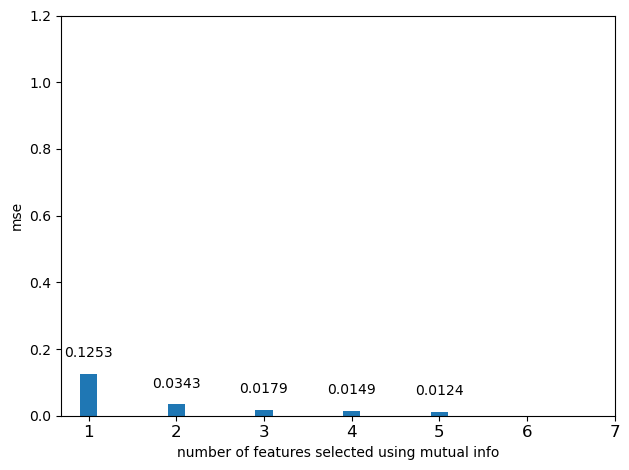

In [27]:
fig, ax = plt.subplots()

x = np.arange(1, col + 1)
y = mse_list

ax.bar(x, y, width= 0.2)
ax.set_xlabel ("number of features selected using mutual info")
ax.set_ylabel ("mse")
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1,8))
ax.set_xticklabels(np.arange(1, 8), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')
plt.tight_layout()

In [28]:
# top features selected
selector = SelectKBest(mutual_info_regression, k=4)
selector.fit(X_train1, y_train1)

selected_feature_mask = selector.get_support()
#X_scaled = pd.DataFrame(scaler_x.fit_transform(X), columns=X.columns)
selected_features = X1.columns[selected_feature_mask]
selected_features

Index(['KLOC', 'SCRN', 'FILE', 'ESCRN'], dtype='object')

- From the plot above and comparing the mse to the first step (correlation) mse, there is no need for further feature selection

In [29]:
# Running the Jaya-svr optimization with new selected features

In [30]:
def jaya_optimizer(fitness_fn, bounds, pop_size=10, iterations=100):
    dim = len(bounds)
    population = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds], size=(pop_size, dim))
    mse_per_iter = []

    for it in range(iterations):
        fitness_values = [fitness_fn(ind, X_train1, y_train1) for ind in population]
        best_idx, worst_idx = np.argmin(fitness_values), np.argmax(fitness_values)
        best, worst = population[best_idx], population[worst_idx]

        for i in range(pop_size):
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            new_ind = population[i] + r1 * (best - abs(population[i])) - r2 * (worst - abs(population[i]))
            new_ind = np.clip(new_ind, [b[0] for b in bounds], [b[1] for b in bounds])
            new_fit = fitness_fn(new_ind, X_train1, y_train1)
            if new_fit < fitness_values[i]:
                population[i] = new_ind

        mse_per_iter.append(min(fitness_values))

    final_fitness = [fitness_fn(ind, X_train1, y_train1) for ind in population]
    best_index = np.argmin(final_fitness)
    return population[best_index], final_fitness[best_index], mse_per_iter

In [31]:
best_params, best_mse, mse_progression = jaya_optimizer(fitness_function, bounds, pop_size=10, iterations=100)

print("Best Parameters (C, epsilon, gamma):", best_params)
print("Best MSE on validation set:", best_mse)

Best Parameters (C, epsilon, gamma): [1.00000000e+03 5.00000000e-02 1.46661522e-03]
Best MSE on validation set: 0.014084844105329793


In [32]:
# Now evaluate the best model on the test set (unseen data)
best_model = SVR(C=best_params[0], epsilon=best_params[1], gamma=best_params[2])
best_model.fit(X_train1, y_train1)
y_test_pred = best_model.predict(X_test1)
test_mse = mean_squared_error(y_test1, y_test_pred)
print("Test MSE on unseen data:", test_mse)

Test MSE on unseen data: 0.01204161234390925


In [33]:
y_test_predr = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))  # Reverse scaling to get the original values
y_testr = scaler_y.inverse_transform(y_test1.reshape(-1, 1))
print(y_predr[:6])
print(y_testr[:6])
print("mse: ", mean_squared_error(y_testr, y_test_predr))

[[ 63.51531584]
 [ 75.50945276]
 [128.79152446]
 [ 26.79642631]
 [ 67.58295548]
 [ 44.62778892]]
[[ 39. ]
 [ 55.7]
 [157. ]
 [  6. ]
 [ 54. ]
 [ 22. ]]
mse:  617.0217369016693


# Final Results:
    Based on all the test runs, this is the conclusion:
###  Results without feature selection (MSE)
- SVR only -> 0.014037098682665904          | reversed scale: 719.2720345809466
- JAYA-SVR -> 0.013353536085011877          | reversed scale: 684.245746635476
###  Results with feature selection
- SVR only -> 0.01244025517414928           | reversed scale: 637.4485107001561
- JAYA-SVR -> 0.01204161234390925          | reversed scale: 617.0217369016693

### Using feature selection improved the model's prediction and optimizing the model using JAYA algorithm further improved the model... on this dataset

## Results from the published paper, for this dataset
- BPNN only -> 0.3067
- SSA-BPNN -> 0.0035
> Back Propagation Neural Network (BPNN) & Salp Swarm Algorithm (SSA)

#### Confusion???
Why is the result better when the dataset is scaled down but looks worse when the scaling is reversed?